# Modelos lineales regularizados

## Instalación

In [1]:
R.version.string

[1] "R version 4.1.3 (2022-03-10)"

In [2]:
packages <- c("devtools"
  ,"randomForest" 
  ,"rpart" # decision tree
  ,"rpart.plot" # enhanced tree plots
  ,"ROCR"
  ,"Hmisc"
  ,"corrplot"
  ,"texreg"
  ,"glmnet"
  ,"reshape2"
  ,"knitr"
  ,"xtable"
  ,"lars"
  ,"ggplot2"
  ,"matrixStats"
  ,"plyr"
  ,"stargazer")

In [3]:
not_installed <- !packages %in% installed.packages()
if (any(not_installed)) install.packages(packages[not_installed])

## Preparación de datos


In [4]:
unzip(zipfile = 'Datos/socialneighbor.zip')
social <- read.csv('socialneighbor.csv')

In [5]:
colnames(social)

[1] "sex"                          "yob"                         
 [3] "g2000"                        "g2002"                       
 [5] "g2004"                        "p2000"                       
 [7] "p2002"                        "cluster"                     
 [9] "votedav"                      "dem"                         
[11] "nov"                          "aug"                         
[13] "city"                         "hh_id"                       
[15] "hh_size"                      "totalpopulation_estimate"    
[17] "percent_male"                 "percent_female"              
[19] "median_age"                   "percent_under5years"         
[21] "percent_5to9years"            "percent_10to14years"         
[23] "percent_15to19years"          "percent_20to24years"         
[25] "percent_25to34years"          "percent_35to44years"         
[27] "percent_45to54years"          "percent_55to59years"         
[29] "percent_60to64years"          "percent_65to74years"         
[31] "percent_75to84years"          "percent_85yearsandolder"     
[33] "percent_18yearsandolder"      "percent_21yearsandover"      
[35] "percent_62yearsandover"       "percent_65yearsandover"      
[37] "percent_white"                "percent_black"               
[39] "percent_amindian_alaskan"     "percent_asian"               
[41] "percent_nativeandother"       "percent_other_nativeandother"
[43] "percent_hispanicorlatino"     "percent_race_other"          
[45] "median_income"                "mean_income"                 
[47] "employ_16"                    "unemploy_16"                 
[49] "unemploy_20to64"              "employ_20to64"               
[51] "employ_rename_20to64"         "hsorhigher"                  
[53] "bach_orhigher"                "less9thgrade"                
[55] "grade9to12"                   "highschool"                  
[57] "somecollege"                  "assoc"                       
[59] "bachelors"                    "grad"                        
[61] "outcome_voted"                "treatment_dum"               
[63] "treat_hawthorne"              "treat_civic"                 
[65] "treat_neighbors"              "treat_self"                  
[67] "randn"                        "oneperhh"                    
[69] "p2004"

In [6]:
set.seed(123)
noise.covars <- matrix(data = runif(nrow(social) * 13), 
                       nrow = nrow(social), ncol = 13)
noise.covars <- data.frame(noise.covars)
names(noise.covars) <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6",
                         "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")


In [7]:
working <- cbind(social, noise.covars)

set.seed(333)
#working <-  working[sample(nrow(social), 20000), ]

# Pick a selection of covariates
# If we have a lot of data and computation power, it is suggested that
# we include all covariates and use regularization. This suggestion is
# based on the observation that it's much easier to fix the overfitting 
# problem than to fix the underfitting problem.
covariate.names <- c("yob", "hh_size", "sex", "city", "g2000","g2002", "p2000", "p2002", "p2004"
                     ,"totalpopulation_estimate","percent_male","median_age", "percent_62yearsandover"
                     ,"percent_white", "percent_black", "median_income",
                     "employ_20to64", "highschool", "bach_orhigher","percent_hispanicorlatino",
                     "noise1", "noise2", "noise3", "noise4", "noise5", "noise6",
                     "noise7", "noise8", "noise9", "noise10", "noise11", "noise12","noise13")


names(working)[names(working)=="outcome_voted"] <- "Y"
Y <- working[["Y"]]

In [8]:
names(working)[names(working)=="treat_neighbors"] <- "W"

In [9]:
W <- working[["W"]]
covariates <- working[covariate.names]

In [10]:
names(covariates)

[1] "yob"                      "hh_size"                 
 [3] "sex"                      "city"                    
 [5] "g2000"                    "g2002"                   
 [7] "p2000"                    "p2002"                   
 [9] "p2004"                    "totalpopulation_estimate"
[11] "percent_male"             "median_age"              
[13] "percent_62yearsandover"   "percent_white"           
[15] "percent_black"            "median_income"           
[17] "employ_20to64"            "highschool"              
[19] "bach_orhigher"            "percent_hispanicorlatino"
[21] "noise1"                   "noise2"                  
[23] "noise3"                   "noise4"                  
[25] "noise5"                   "noise6"                  
[27] "noise7"                   "noise8"                  
[29] "noise9"                   "noise10"                 
[31] "noise11"                  "noise12"                 
[33] "noise13"

Algunos algoritmos necesitan que las covariables sean escaladas para que funcionen mejor. En este caso vamos a usar la función "scale" para hacerlo.

In [11]:
# some algorithms require our covariates be scaled
# scale, with default settings, will calculate the mean and standard deviation of the entire vector, 
# then "scale" each element by those values by subtracting the mean and dividing by the sd
covariates.scaled <- scale(covariates)
processed.unscaled <- data.frame(Y, W, covariates)
processed.scaled <- data.frame(Y, W, covariates.scaled)

El objetivo principal de machine learning es la predicción fuera de la muestra, es por eso que lo que se hace habitualmente para simularlo es partir la muestra de datos en dos, una muestra de entrenamiento y la otra de testeo. Incluso se suele dividir en tres también, lo que sería entrenamiento, validación y testeo. Para partir los datos usamos la función "sample"

In [12]:
# Creemos una función que nos devuelvo dos bd

train_test <- function(bd, porcentaje) {
    train <- sample(nrow(bd), round(nrow(bd)*porcentaje), replace = FALSE)
    train.bd <- bd[train,]
    test.bd <- bd[-train,]
    return(list(train.bd,test.bd))
    }

set.seed(45)
lista_train_test <- train_test(processed.scaled, 0.9)
y.train <- as.matrix(lista_train_test[[1]]$Y, ncol = 1)
y.test <- as.matrix(lista_train_test[[2]]$Y, ncol = 1)
X.train <- lista_train_test[[1]]
X.test <- lista_train_test[[2]]

Creamos las formulas que vamos a trabajar

In [13]:
sumx <- paste(covariate.names, collapse = " + ")  # "X1 + X2 + X3 + ..." for substitution later
interx <- paste(" (",sumx, ")^2", sep="")  # "(X1 + X2 + X3 + ...)^2" for substitution later
linear <- paste("Y", sumx, sep = "~")
linear <- as.formula(linear)
linear.inter <- (paste("Y", interx, sep = "~"))
linear.inter <- as.formula(linear.inter)

## Modelos lineales

### Mínimos cuadrados ordinarios

Cuándo hablamos de modelos lineales para predicción estamos suponiendo que la función $E(Y|X)$ es lineal en las entradas $X_1,...,X_p$. Por lo tanto podemos tomar un vector $X^T=(X_1,...,X_p)$ y predecir $y$ con la siguiente función:

\begin{equation}
f(X)=\beta_{0}+\sum_{j=1}^{p}\boldsymbol{X}_{j}\beta_{j}
\end{equation}

En esta ecuación los parámetros $\beta_j$ son desconocidos y $\boldsymbol{X}$ es una matriz de datos conocidos.
EL objetivo es estimar los coeficientes $\beta=\left(\beta_0,\beta_1,...,beta_p\right)^T, para esto, el método mas popular es el de mínimos cuadrados el cual tiene como objetivo reducir la suma de cuadrados de los residuos.

\begin{equation}
RSS\left(\beta\right) = \sum_{i=1}^{N}\left(y_i-\sum_{j=0}^{p}x_{ij}\beta_j\right)^2
\end{equation}

Para minimizarla podemos escrbirla de la siguiente forma:

\begin{equation}
RSS\left(\beta\right) = \left(\boldsymbol{y}-\boldsymbol{X}\beta\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\beta\right)
\end{equation}

luego derivando e igualando a 0 tenemos:

\begin{equation}
\boldsymbol{X}^T\boldsymbol{y}-\boldsymbol{X}^T\boldsymbol{X}\beta = 0
\end{equation}

Asumiendo que $\boldsymbol{X}$ tiene rango completo de columnas podemos encontrar una única solución dada por:

\begin{equation}
\hat{\beta} = \left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}
\end{equation}

Una condición necesaria para aplicar esta estimación es que las columnas de $\boldsymbol{X}$ sean independientes entre sí, en otro caso no tendríamos rango completo de columna. La función *lm* de R elimina aquellas columnas redundantes de la estimación y lo calcula, la mayoría de los software estadísticos lo hacen, pero no ocurre así si quisieramos aplicar este cálculo por nuestra cuenta.

Como se mencionó la función *lm* es el comando para calcular mínimos cuadrados en R. Los parámetros básicos para calcularla son una fórmula del objeto de tipo *"formula"* de R el cuál deberá tener cuál es la variable dependiente y cuales son las variables explicativas y la base de datos de dónde sale dicha información.

Procedemos a ver un ejemplo con los datos de social.csv


In [14]:
# la fórmula es
linear

Y ~ yob + hh_size + sex + city + g2000 + g2002 + p2000 + p2002 + 
    p2004 + totalpopulation_estimate + percent_male + median_age + 
    percent_62yearsandover + percent_white + percent_black + 
    median_income + employ_20to64 + highschool + bach_orhigher + 
    percent_hispanicorlatino + noise1 + noise2 + noise3 + noise4 + 
    noise5 + noise6 + noise7 + noise8 + noise9 + noise10 + noise11 + 
    noise12 + noise13

In [15]:
ols <- lm(linear, processed.scaled)
summary(ols)


Call:
lm(formula = linear, data = processed.scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7798 -0.3387 -0.2182  0.5444  1.0269 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.3183027  0.0012972 245.378  < 2e-16 ***
yob                      -0.0298619  0.0014321 -20.851  < 2e-16 ***
hh_size                   0.0079806  0.0013736   5.810 6.27e-09 ***
sex                      -0.0041355  0.0012990  -3.184  0.00145 ** 
city                      0.0425474  0.0013905  30.599  < 2e-16 ***
g2000                    -0.0098765  0.0014243  -6.934 4.11e-12 ***
g2002                     0.0293672  0.0014239  20.625  < 2e-16 ***
p2000                     0.0377639  0.0013333  28.324  < 2e-16 ***
p2002                     0.0576975  0.0013488  42.777  < 2e-16 ***
p2004                     0.0756268  0.0013289  56.911  < 2e-16 ***
totalpopulation_estimate  0.0103734  0.0016749   6.193 5.90e-10 ***
percent_male          

Como se puede ver, el método de mínimos cuadrados considera a los ruidos que agregamos nosotros como significativos, por lo tanto no tiene la capacidad de detectar que es ruido, simplemente las ajusta junto a todas las otras. Esto agrega otro supuesto más a MCO que tenemos que tener en cuenta, que es que tenemos que tener bien especificado el modelo, o sea todas las variables que pasamos como explicativas deben ser realmente las variables que explican a $y$. Esto es particularmente dificil en los casos reales, y la idea es tratar de encontrar las variables que explican el modelo a través de métodos de selección de variables, los cuales nos deberían acercar a la verdadera función.

De todas formas, si el método predice bien podemos tomarlo aunque tenga variables ruidosas, el objetivo acá es la predicción. Para chequear que tan bueno es un método para predcir por lo general se usa lo de partir la base de datos en dos, una grande que sirve para los datos de entrenamiento y otra más pequeña para el testeo. La idea es la predicción por fuera de la muestra. Luego con los coeficientes calculados con los datos de entrenamiento se predice sobre la base de prueba y se mide que tan efectivo es con alguna métrica.

In [16]:
ols <- lm(linear, data = X.train)

In [17]:
summary(ols)


Call:
lm(formula = linear, data = X.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7801 -0.3387 -0.2187  0.5445  1.0288 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.3183863  0.0013677 232.794  < 2e-16 ***
yob                      -0.0285834  0.0015083 -18.951  < 2e-16 ***
hh_size                   0.0076376  0.0014473   5.277 1.32e-07 ***
sex                      -0.0044537  0.0013695  -3.252  0.00115 ** 
city                      0.0435412  0.0014667  29.686  < 2e-16 ***
g2000                    -0.0094400  0.0015004  -6.292 3.15e-10 ***
g2002                     0.0297059  0.0015024  19.773  < 2e-16 ***
p2000                     0.0377601  0.0014057  26.862  < 2e-16 ***
p2002                     0.0570572  0.0014225  40.111  < 2e-16 ***
p2004                     0.0754573  0.0014011  53.857  < 2e-16 ***
totalpopulation_estimate  0.0114049  0.0017666   6.456 1.08e-10 ***
percent_male             -0.004

Una forma de medir la efectividad del método para predecir es utilizando el error cuadrático medio, existen varias más, el error abosluto medio, el error logarítmico cuadrado medo, etc. Estos son los utilizados para medir la efectividad de las regresiones.

En R no están de manera predeterminada por lo tanto procedemos a armarlos con una función nosotros.

In [18]:
mse <- function(pred, y_test){
    return((mean((pred-y_test)^2)))
    }   

La función *predcit* en R es una función genérica que se puede aplicar a distintos objetos, solo que depende cual sea recibe parámetros distintos. Esto es parte de lo que se denomina *polimorfismo* en la programación orientada a objeto.

Es por eso que la hay que calcular las predicciones primero y luego calcular la métrica. Como se puede ver el primer número que es sobre la base de test, es mayor que sobre la base de entrenamiento, aunque son bastantes similares

In [19]:
ols_pred <- predict(ols, X.test)
ols_rdos <- c( mse_train = mse(predict(ols, X.train), y.train),mse_test = mse(ols_pred, y.test))
ols_rdos

mse_train  mse_test 
0.2019455 0.2012196

Esta son las métricas para evaluar una regresión, pero en nuestro ejemplo la variable respuesta es una variable binomial, por lo tanto es un problema de clasificación y no de regresión. Existen otro tipo de métricas para poder evaluar un método de estimación cuando el problema es de predicción, entre ellos los más conocidos son **precision** y **recall**. Para observar esto miremos lo que se conoce como matriz de confusión.

![image.png](attachment:0818f836-dd79-4170-bae3-a750d5515cb2.png)

Entonces la precision o valor predictivo positivo  va medir a todos aquellos a los que predecimos como positivos y es verdad (verdaderos positivos) sobre todos los que predecimos como verdaderos. Más formal $VP/(VP+FP)$.

El recall o sensibilidad va medir a todos los verdaderos positivos sobre todos los que son positivos realmente. Más formal $VP/(VP+FN)$

La especificidad o razon de verdaders negativos mide todos aquellos que son verdaderos negativos sobre todos los negativos reales. Más formal $VN/(FP+VN)$



Estos indicadores deben estar balanceados entre sí, no se puede intentar mejorar solo uno. Por ejemplo si aumentamos la precisión llevandola a 1, significa que acertamos a todos los que son verdaderamente positivos, pero esto, probablemente traiga aparejada que tenemos muchos falsos positivos también, por lo tanto puede ser indicio de sobre ajuste (*overfitting*). En cambio si mejoramos el recall, procurando no tener falsos negativos, puede dar indicios de sub-ajuste (*underfittinh*). 

Existe unfa fórmula que los unifica a la precision y al recall para trabajar de manera unificada, estos se conocen como las medidas $F_1$. En este caso la fórmula es la siguiente:
\begin{equation}
F_1 = \frac{2}{1/prec+1/rec}
\end{equation}

Este indicador va de 0 a 1 siendo 1 el mejor resultado.

Estos indicadores no se encuentran en R pero también son fáciles de calcular con una función propia


In [20]:
#definimos una función clasificadora de ols
clasif <- function(pred, p){
    r = pred > p
    return(as.numeric(r))
    }
clasif(ols_pred, 0.5)

[1] 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
   [37] 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
   [73] 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  [109] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [145] 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  [181] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [217] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  [253] 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  [289] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  [325] 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  [361] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  [397] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  [433] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  [469] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  [505] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  [541] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  [577] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [613] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [649] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  [685] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [721] 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
  [757] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [793] 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0
  [829] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [865] 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  [901] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [937] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  [973] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 [1009] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1045] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 [1081] 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 [1117] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1153] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [1189] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 [1225] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [1261] 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1297] 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 [1333] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 [1369] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1405] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 [1441] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 [1477] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [1513] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 [1549] 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1585] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 [1621] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [1657] 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 [1693] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 [1729] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [1765] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [18

In [21]:
confusion <- function(pred, y){
    vp = 0
    fp = 0
    fn = 0
    vn = 0
    for (i in 1:length(pred)){
        if(pred[i] == 1 ){
            if(pred[i] == y[i]){
                vp <- vp+1}
            else{
                fp <- fp+1}
               }
        else{
             if(pred[i] != y[i]){
                fn <- fn+1}
            else{
                vn <- vn+1
                }
            }}
        return(cbind(c(vp,fp),c(fn,vn)))
        }

f1_score <- function(pred,y) {
    val <- confusion(pred,y)
    prec <- val[1]/(val[1]+val[2])
    rec <- val[1]/(val[1]+val[3])
    f1 <- 2/(prec^-1+rec^-1)
    return(f1)}

In [22]:
confusion(clasif(ols_pred, 0.3),y.test)

2726,1072
4176,4026


In [23]:
ols_rdos['f1'] <- f1_score(clasif(ols_pred, 0.3),y.test)
ols_rdos['f1']

f1 
0.5095327

Como se puede observar el modelo mínimos cuadrados ya no parece ser tan buen modelo para clasificaciones. 

### Modelo logit

El problema que tiene el modelo lineal para determinar una probabilidad, es que a menudo arroja valores negativos o valores mayores a 1, lo que no son valores que puedan identificarse como probabilidades. Para solucionar esto, se considera la función logística que devuelve todos valores entre 0 y 1.

\begin{equation}
p\left(y = 1|\boldsymbol{X}=x\right)=p\left(\boldsymbol{X}\right) = \frac{e^{\boldsymbol{X}\boldsymbol{\beta}}}{1+e^{\boldsymbol{X}\boldsymbol{\beta}}}
\end{equation}

Si aplicamos transformaciones podemos ver que la ecuación nos queda de la siguiente forma:

\begin{equation}
log\left(\frac{p\left(\boldsymbol{X}\right)}{1-p\left(\boldsymbol{X}\right)}\right) = \boldsymbol{X}\boldsymbol{\beta}
\end{equation}

la proporción $\frac{p\left(\boldsymbol{X}\right)}{1-p\left(\boldsymbol{X}\right)}$ se denomina *odds*, y puede tomar valores que van del 0 al $\infty$. Como podemos ver el modelo de regresión sigue siendo lineal en $\boldsymbol{X}$ pero con respecto al *log-odds* que es como se denomina a la parte de la izquierda de la ecuación anterior.

La forma de estimar este modelo es a través de máxima verosimilitud, en el cual no vamos a entrar en detalles acá.

Para realizar la estimación en R, se utiliza la función *glm*. La forma de uso es muy similar a *lm* necesita que le pasemos la fórmula a estimar y los datos necesarios como variables principales. Además se le agrega la variable *family* en la cual hay que colocarle que queremos estimar una *binomial*. Esta función en R es mucho más amplia que solo para estimar modelos logit, en realidad funcióna para estimar cualquier modelo lineal generalizado, lo que hay que variar es el parámetro *family*.

In [24]:
logit <- glm(linear, data = X.train, family = "binomial")

In [25]:
summary(logit)


Call:
glm(formula = linear, family = "binomial", data = X.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7921  -0.8927  -0.6873   1.2404   2.3396  

Coefficients:
                          Estimate Std. Error  z value Pr(>|z|)    
(Intercept)              -0.827108   0.006952 -118.976  < 2e-16 ***
yob                      -0.146646   0.007391  -19.841  < 2e-16 ***
hh_size                   0.021169   0.007162    2.956  0.00312 ** 
sex                      -0.021452   0.006784   -3.162  0.00157 ** 
city                      0.205738   0.006960   29.560  < 2e-16 ***
g2000                    -0.033104   0.007648   -4.328 1.50e-05 ***
g2002                     0.175047   0.008076   21.676  < 2e-16 ***
p2000                     0.179223   0.006727   26.642  < 2e-16 ***
p2002                     0.274766   0.006917   39.722  < 2e-16 ***
p2004                     0.370565   0.006940   53.393  < 2e-16 ***
totalpopulation_estimate  0.055280   0.008801    6.281 3.

La función predict también es aplicable a los modelos logit, pero a estos hay que agregarles el parámetro *type* en el cual hay que poner response. En otro caso, nos devolvera la probabilidad en escala logarítmica.

In [26]:
logit_pred <- predict(logit,X.test, type = "response")
logit_rdos <- c('mse_logit' = mse(predict(logit, type = "response"), y.train),',mse_test' = mse(logit_pred, y.test)) 
logit_rdos

mse_logit ,mse_test 
0.2019257 0.2014333

In [27]:
# La fórmula predict en el logit devuelve una probabilidad entonces tampoco arroja valores 0 o 1 como la clasificación que queremos, por lo tanto lo tenemos que separar en base a un criterio
# usamos la función creada antes
clasif(logit_pred, 0.5) 
logit_rdos['f1'] <- f1_score(clasif(logit_pred, 0.3) , y.test)

[1] 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0
   [37] 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
   [73] 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  [109] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [145] 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  [181] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [217] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  [253] 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  [289] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  [325] 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  [361] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  [397] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  [433] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  [469] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  [505] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  [541] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  [577] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [613] 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [649] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0
  [685] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [721] 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
  [757] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [793] 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0
  [829] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [865] 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  [901] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [937] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
  [973] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 [1009] 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 [1045] 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 [1081] 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 [1117] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 [1153] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [1189] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 [1225] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [1261] 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1297] 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 [1333] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 [1369] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1405] 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 [1441] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 [1477] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 [1513] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 [1549] 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1585] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 [1621] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 [1657] 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 [1693] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 [1729] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [1765] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [18

In [28]:
logit_rdos['f1']

f1 
0.5027429

In [29]:
# ponemos ambos modelos en un df que va agrupando los resultados
rdos <- cbind(ols_rdos,logit_rdos)
rdos

,ols_rdos,logit_rdos
mse_train,0.2019455,0.2019257
mse_test,0.2012196,0.2014333
f1,0.5095327,0.5027429


In [30]:
ols2 <- lm(linear.inter, data = X.train)


In [31]:
logit2 <- glm(linear.inter, data = X.train, family = "binomial")
#mse(logit2, X.train, X.test)

### Regresion con descomposcición de valores singulares

Un método utilizado por los sowtwares de predicción en machine learning es la regresión utilizando la pseudo inversa de la matriz de datos. Para encontrar dicha pseudo-inversa se utiliza la descomposición de valores singulares. Sea $A$ una matriz $n\ x\  p$ 

\begin{equation}
A = U\Sigma V^T
\end{equation}

siendo $U$ una matriz $n\ x\ n$ , $\Sigma$ es una matriz $m\ x\ p$ y $V^T$ es una matriz cuadrada $p\ x\ p$. Las matrices $U$ y $V^T$ son matrices unitarias lo que les da unas propiedades muy convenientes ya que $UU^T\ =\ I$ y $VV^T\ =\ I$. Por otro lado $\Sigma$ es una matriz diagonal sólo en en sus primeros $r$ renglones siendo $r=\ min(n,p)$ llenando todos los demás espacios con ceros, que suelen eliminarse. La primera ventaja que proporciona este método es que no importa la forma de la matriz, siempre se puede descomponer en estas tres matrices mencionadas, incluso cuando $p > n$.

Dado un sistema de ecuaciones, podemos resolverlo con la descomposición mencionada.

\begin{equation}
Ax\ =\ b 
\end{equation}

\begin{equation}
(U\Sigma V^T)^{-1}(U\Sigma V^T)x\ =\ (U\Sigma V^T)^{-1}b 
\end{equation}

\begin{equation}
\hat{x}\ =\ V\Sigma^{-1}U^Tb
\end{equation}

Cómo vemos las matriz descompuesta es muy fácil de invertir. La complejidad computacional en usar este método es al rededor de $O\left(n^2\right)$ mientras que con el método normal la complejidad es de alrededor de $O\left(n^{2.4}\right)$ hasta $O\left(n^3\right)$

En R podemos encontrar la función *svd* que permite descomponer las matrices, luego con está podemos construir la regresión.

In [32]:
# está función reg.svm devuelve los coeficientes calculados bajo este método
reg.svm <- function(modelo, y,X) {
    X <- model.matrix(modelo,X) #la función model.matrix devuleve la matriz de acuerdo a la fórmula
    dX <- svd(X)
    x_hat <- (dX$v) %*% solve(diag(dX$d)) %*% t(dX$u) %*% y
    #y_pred <- X %*% x_hat
    return(x_hat)
    }
#creamos una función predict

predict.svm <- function(modelo, X, coef){
    pred <- model.matrix(modelo,X) %*% coef
    return(pred)
           }


In [33]:
coef <- reg.svm(linear, y.train, X.train)
pred_train <- predict.svm(linear, X.train, coef)
pred_test <- predict.svm(linear, X.test, coef)

svm_rdos <- c('mse_train' = mse(pred_train, y.train), 'mse_test' = mse(pred_test, y.test))
svm_rdos

mse_train  mse_test 
0.2019455 0.2012196

In [34]:
#sigue con el mismo problema de clasificación usamos la función clasif creada y calculamos el f1
svm_rdos['f1'] <- f1_score(clasif(pred_test,0.3), y.test)
svm_rdos['f1']

f1 
0.5095327

In [35]:
rdos <- cbind(rdos,svm_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos
mse_train,0.2019455,0.2019257,0.2019455
mse_test,0.2012196,0.2014333,0.2012196
f1,0.5095327,0.5027429,0.5095327


### Ridge regresión

El teorema Gauss-Markov dice que el estimador de mínimos cuadrados es el mejor estimador lineal insesgado, pero puede ser que exista un estimador que sea sesgado y mejor. Esta discusión pasa por un trade-off entre el sesgo y la varianza muy usual en machine learning, como los objetivos acá no son la estimación si no la predicción se prefiere un estimador que sea sesgado mientras disminuya la varianza. Esto sucede con los estimadores restringidos. 

El estimador que proviene de la ridge regresión surje de solucionar el siguiente problema:

\begin{equation}
\hat{\beta}^{ridge} = argmin_β\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2\right)^2
\end{equation}
\begin{equation}
sujeto\ a\ \sum_{j=1}^p\beta_j^2\ <= t
\end{equation}

Resolviendo el problema el estimador nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{ridge} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2\right)^2 + λ\sum_{j=1}^p\beta_j^2\right\}
\end{equation}

El parámetro $\lambda$ es el que regulariza los estimadores llevando a 0 los parámetros. La regresión ridge no es invariante a las escalas de los parámetros, es por eso que se deben estandarizar las variables previo a hacer los cálculos. 

Si escribimos el problema en forma matricial nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{ridge} = \left(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I} \right)^{-1}\boldsymbol{X}^T\boldsymbol{y} 
\end{equation}

La matriz $\boldsymbol{X}^T\boldsymbol{X}$ puede no tener rango completo, incluso son los principales problemas perseguidos con este tipo de regresión y la forma de solucionarlo es con la descomposición de valores singulares.

Para trabajar la regresión ridge y LASSO usamos el paquete glmnet y la función de ese mismo paquete. La forma de determinar cual vamos a utilizar es con el parámtero alpha, si este es 0 la regresión es ridge y si es 1 es LASSO.

EL parámetro a identficar es el parámetro $\lambda$, no hay una forma de saber que valor poner a este parámetro por eso lo ideal es hacer varias regresiones y tomar el que mejores resultados, para ello se hace un grid con un rango de posibles valores para lambda, en este caso desde $10^{10}$ hasta $10^{-2}$ 

In [36]:
require(glmnet)
grid <- 10^seq(10,-2, length = 100)
ridge.mod <- glmnet(model.matrix(linear, X.train), y.train, alpha = 0, lambda = grid)

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-4



Lo que la función "glmnet" ha hecho ahora es calcular 100 regresiones para los distintos valores de $\lambda$ que le pasamos, por lo tanto cuando queremos consultar los coeficientes que arroja el modelo, se hace con el método "coef" y este va arrojar una matriz de k * 100 siendo k la cantidad de coeficientes que estamos estimando.

In [37]:
dim(coef(ridge.mod))

[1]  35 100

El hiper parámetro $\lambda$ se selecciona con cross-validation. Recordemos que la elección de los bloques en las carpetas de cross-validation se hace de manera aleatoria, entonces para poder repetir el experimento es necesario pasarle una semilla al software, así siempre nos arroja los mismos datos

Para ejecutar la cross-validation en R se utiliza la función cv.glmnet y los parámetros que recibe son los mismos que los que recibe glmnet y se le agregan los de cross-validations. El argumento lambda es opcional, se puede pasar una lista propia o si se deja vació el programa tomara distintos lambda por defecto. La cantidad de carpetas está por defecto en 10 que también puede ser modificada. Entre los argumentos de salida podemos encontrar a lambda.min que representa el valor de lambda que minimiza el error.


[1] 0.04658957

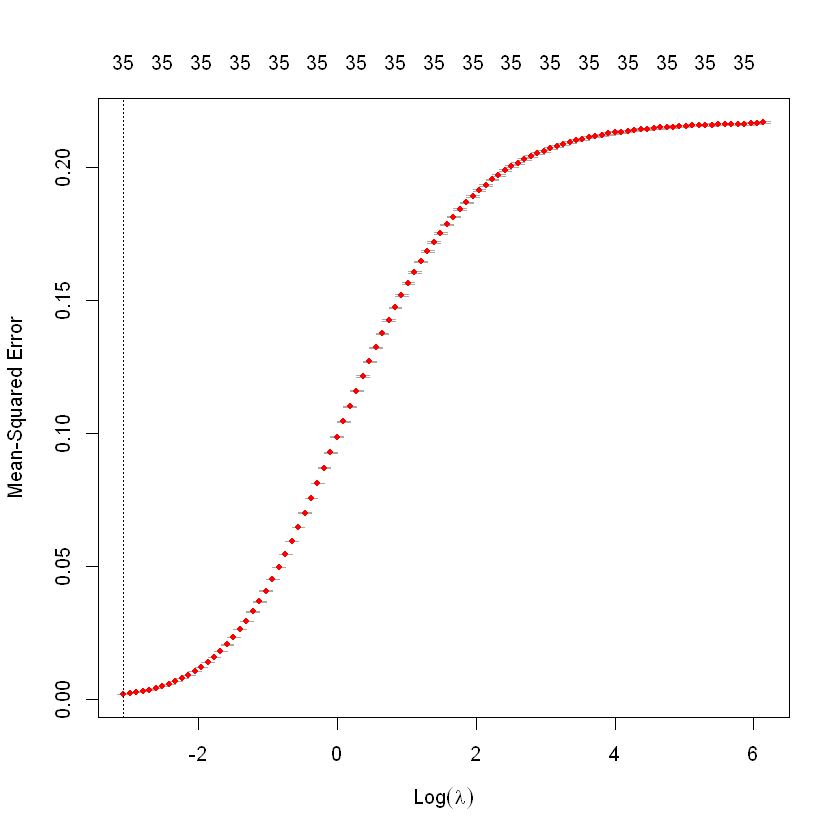

In [38]:
set.seed(154)
cv_ <- cv.glmnet(as.matrix(X.train), y.train, alpha = 0)
plot(cv_)
bestlam <- cv_$lambda.min
bestlam

La función plot aplicada al objeto de cv.glmnet nos muestra un gráfico con los valores de lambda y el error cuadrático medio en el eje y. En este caso se muestra que si incrementamos la penalización el error se va incrementando.

Para predecir los valores volvemos a usar la función predict solo que en este caso le debemos pasar el argumento "s", que se refiere al valor de lambda por el cual queremos estimar.

In [39]:
ridge.pred <- predict(ridge.mod, s= bestlam, newx = (model.matrix(linear, X.test)))
ridge.pred.train <- predict(ridge.mod, s=bestlam, newx = model.matrix(linear, X.train))

ridge_rdos <- c('mse_train' = mse(ridge.pred.train, y.train), 'mse_test' = mse(ridge.pred, y.test))
ridge_rdos

mse_train  mse_test 
0.2021324 0.2014002

In [40]:
# aplciamos clasificación
clas <- clasif(ridge.pred, 0.3)
ridge_rdos['f1'] <- f1_score(clas, y.test)
ridge_rdos['f1']

f1 
0.5113143

In [41]:
rdos <- cbind(rdos, ridge_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324
mse_test,0.2012196,0.2014333,0.2012196,0.2014002
f1,0.5095327,0.5027429,0.5095327,0.5113143


In [42]:
# si queremos ver los coeficientes hay que agregar el argumento "coefficients"
predict(ridge.mod, type = "coefficients", s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)               0.3184022756
(Intercept)               .           
yob                      -0.0260589120
hh_size                   0.0051772359
sex                      -0.0043684285
city                      0.0384384809
g2000                    -0.0064590779
g2002                     0.0281784997
p2000                     0.0342361034
p2002                     0.0516700494
p2004                     0.0672946573
totalpopulation_estimate  0.0079586708
percent_male             -0.0032137090
median_age                0.0054647061
percent_62yearsandover    0.0036362456
percent_white             0.0085212063
percent_black             0.0078908661
median_income             0.0146987121
employ_20to64            -0.0116581171
highschool                0.0127484396
bach_orhigher            -0.0032986286
percent_hispanicorlatino -0.0017423180
noise1                   -0.0002216600
noise2                

### LASSO

La regresión LASSO es muy similar a la ridge, la diferencia es que se cambia la penalización $L2$ por la penalización $L1$. 

\begin{equation}
\hat{\beta}^{lasso} = argmin_β\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2\right)^2
\end{equation}
\begin{equation}
sujeto\ a\ \sum_{j=1}^p|\beta_j|\ <= t
\end{equation}

Resolviendo el problema el estimador nos queda de la siguiente forma:

\begin{equation}
\hat{\beta}^{lasso} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2\right)^2 + λ\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

La restricción de esta regresión lleva los parametros $\beta$ hacia 0 anulando los que no son relevantes para la solución del problema, a diferencia de la ridge que se acerca a 0 asintóticamente. Esta regresión es muy útil para la selección de variables es por eso que ultimamente es más utilizada que la ridge. 

Como ya había mencionado la función para calcular lasso es la misma que la de ridge, solo que ahora se le cambia el parámetro alpha y se pone en valor 1. Lo demás funciona de la mísma manera

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


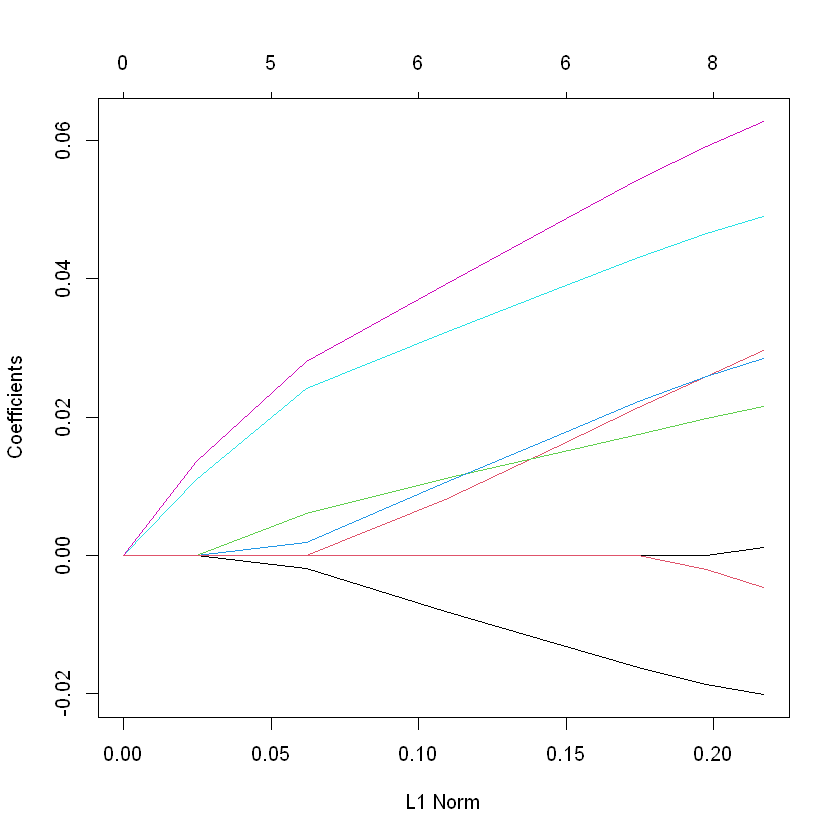

In [43]:
lasso.mod <- glmnet(model.matrix(linear, X.train), y.train, alpha = 1, lambda = grid)
plot(lasso.mod)

[1] 0.0003267912

mse_train  mse_test        f1 
0.2019577 0.2012192 0.5105867

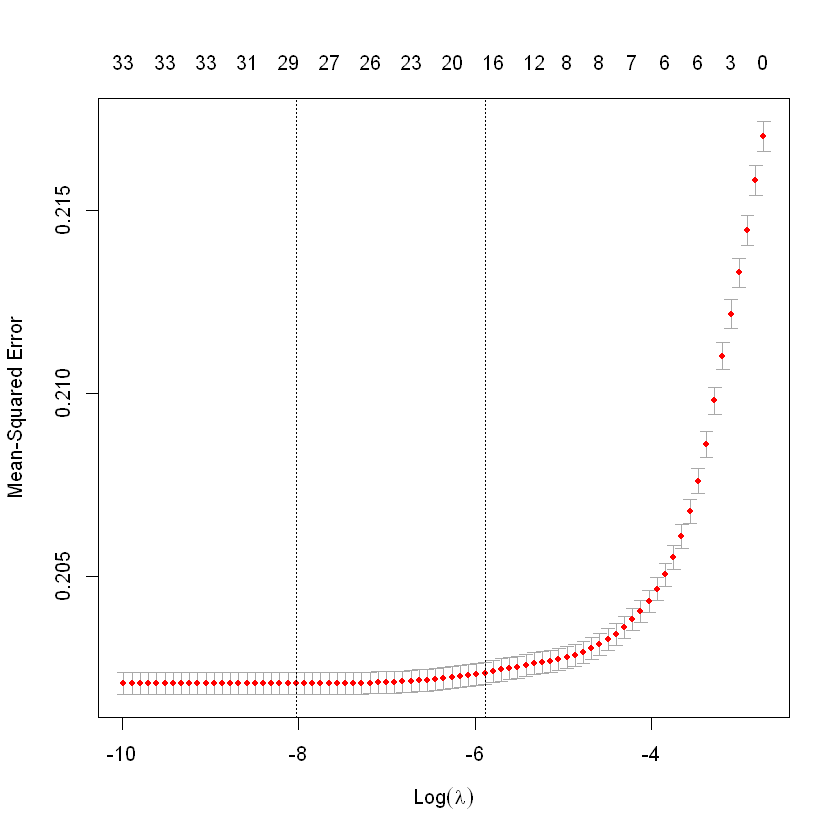

In [44]:
set.seed(154)
#X.train <- model.matrix(linear, as.data.frame(X.train))
#X.test <- model.matrix(linear, as.data.frame(X.test))
cv_lasso <- cv.glmnet(model.matrix(linear,X.train), y.train, alpha = 1)
plot(cv_lasso)
bestlam <- cv_lasso$lambda.min
bestlam

lasso.pred <- predict(cv_lasso, s= bestlam, newx = model.matrix(linear,X.test))
lasso.pred.train <- predict(cv_lasso, s= bestlam, newx = model.matrix(linear,X.train))
clas <- clasif(lasso.pred, 0.3)

lasso_rdos <- c('mse_train' = mse(lasso.pred.train, y.train), 'mse_test' = mse(lasso.pred, y.test), 'f1' = f1_score(clas, y.test))
lasso_rdos

In [45]:
predict(cv_lasso, type = "coefficients", s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)               3.183872e-01
(Intercept)               .           
yob                      -2.816626e-02
hh_size                   7.156824e-03
sex                      -4.172734e-03
city                      4.293234e-02
g2000                    -8.825061e-03
g2002                     2.936918e-02
p2000                     3.743254e-02
p2002                     5.675968e-02
p2004                     7.498304e-02
totalpopulation_estimate  1.022712e-02
percent_male             -3.709430e-03
median_age                2.788469e-03
percent_62yearsandover    6.241068e-03
percent_white             1.488301e-02
percent_black             1.365543e-02
median_income             2.362776e-02
employ_20to64            -1.283373e-02
highschool                2.201891e-02
bach_orhigher             .           
percent_hispanicorlatino  .           
noise1                    .           
noise2                

In [46]:
rdos <- cbind(rdos, lasso_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324,0.2019577
mse_test,0.2012196,0.2014333,0.2012196,0.2014002,0.2012192
f1,0.5095327,0.5027429,0.5095327,0.5113143,0.5105867


Otro argumento de salida que ofrece glmnet es "lambda.1se" este no es el mínimo lambda es pero es el valor que más regulariza y se encuentra dentro del error estandard del mínimo. Se suele utilizar mucho porque a los efectos de seleccionar variables es más estricto.

In [47]:
lasso.pred2 <- predict(cv_lasso, s= cv_lasso$lambda.1se, newx = model.matrix(linear,X.test))
lasso.pred2.train <- predict(cv_lasso, s= cv_lasso$lambda.1se, newx = model.matrix(linear,X.train))
clas <- clasif(lasso.pred2, 0.3)

lasso2_rdos <- c('mse_train' = mse(lasso.pred2.train, y.train), 'mse_test' = mse(lasso.pred2, y.test), 'f1' = f1_score(clas, y.test))
lasso2_rdos

mse_train  mse_test        f1 
0.2022936 0.2013742 0.5100535

In [48]:
rdos <- cbind(rdos, lasso2_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso2_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324,0.2019577,0.2022936
mse_test,0.2012196,0.2014333,0.2012196,0.2014002,0.2012192,0.2013742
f1,0.5095327,0.5027429,0.5095327,0.5113143,0.5105867,0.5100535


In [49]:
predict(cv_lasso, type = "coefficients",s = cv_lasso$lambda.1se)

35 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)               0.3184102134
(Intercept)               .           
yob                      -0.0249206744
hh_size                   0.0035385429
sex                      -0.0021181861
city                      0.0389276178
g2000                    -0.0044323692
g2002                     0.0268710977
p2000                     0.0348893771
p2002                     0.0548121692
p2004                     0.0712812422
totalpopulation_estimate  0.0021933249
percent_male              .           
median_age                0.0065279892
percent_62yearsandover    .           
percent_white             0.0005478882
percent_black             .           
median_income             0.0032295022
employ_20to64            -0.0093657030
highschool                0.0054411236
bach_orhigher             .           
percent_hispanicorlatino -0.0013336100
noise1                    .           
noise2                

### Ridge y Lasso para una regresión logística

Ante el mismo problema de clasificación podemos transformar a ridge o LASSO en una regresión logística agregando el argumento "family = 'binomial'" al comando glmnet o cv.glmnet

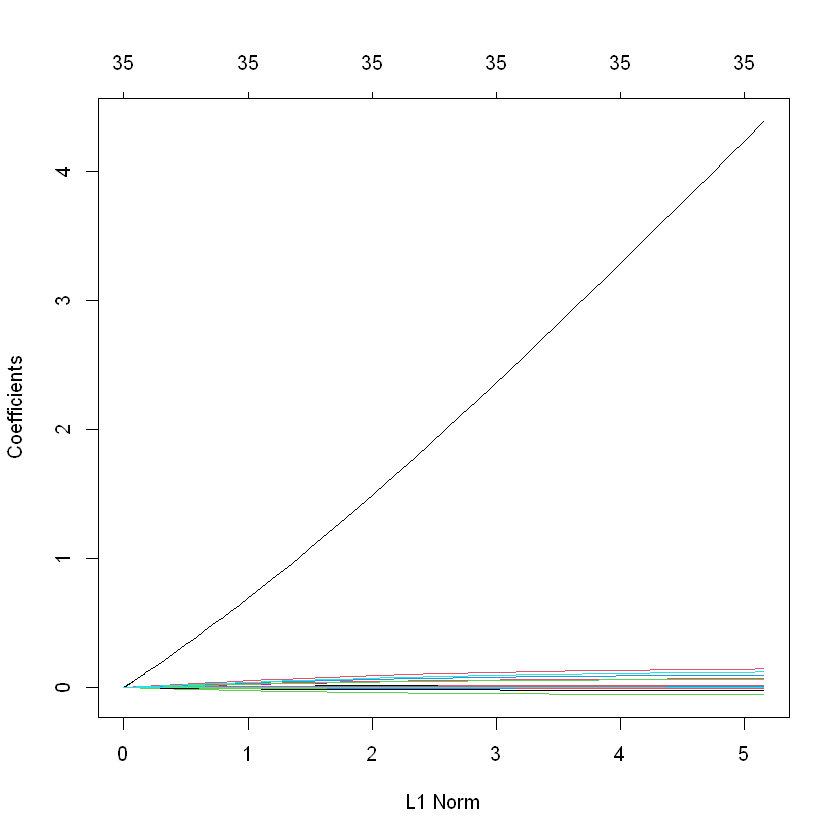

In [50]:
ridge.logit <- glmnet(X.train, y.train, alpha = 0, family = 'binomial')
plot(ridge.logit, label = FALSE)

Warning message in plotCoef(x$beta, lambda = x$lambda, df = x$df, dev = x$dev.ratio, :
"1 or less nonzero coefficients; glmnet plot is not meaningful"


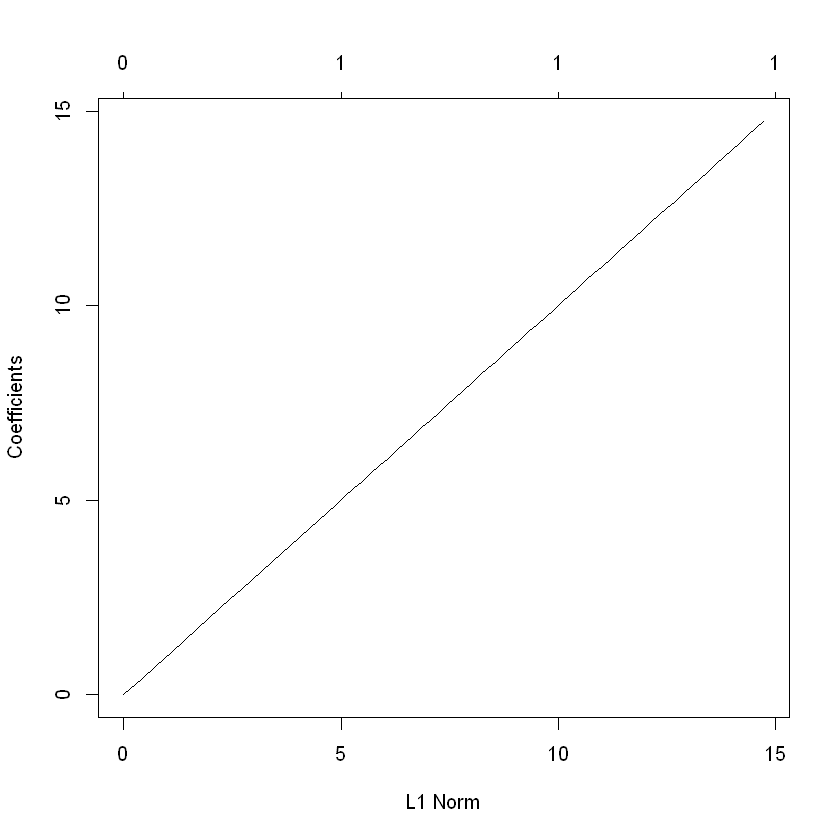

In [51]:
lasso.logit <- glmnet(X.train, y.train, alpha = 1, family = 'binomial')
plot(lasso.logit, label = FALSE)

podemos obtener los coeficientes para uno o mas valoresd e $\lambda$

In [52]:
coef(lasso.logit, s = c(0.03457, 0.007))

36 x 2 sparse Matrix of class "dgCMatrix"
                                s1        s2
(Intercept)              -3.721355 -5.337852
Y                         6.654074  9.909548
W                         .         .       
yob                       .         .       
hh_size                   .         .       
sex                       .         .       
city                      .         .       
g2000                     .         .       
g2002                     .         .       
p2000                     .         .       
p2002                     .         .       
p2004                     .         .       
totalpopulation_estimate  .         .       
percent_male              .         .       
median_age                .         .       
percent_62yearsandover    .         .       
percent_white             .         .       
percent_black             .         .       
median_income             .         .       
employ_20to64             .         .       
highschool   

In [53]:
pre.lasso.logit <- predict(lasso.logit, newx = as.matrix( X.test), 
                   s = c(0.03457, 0.007), type = "response")

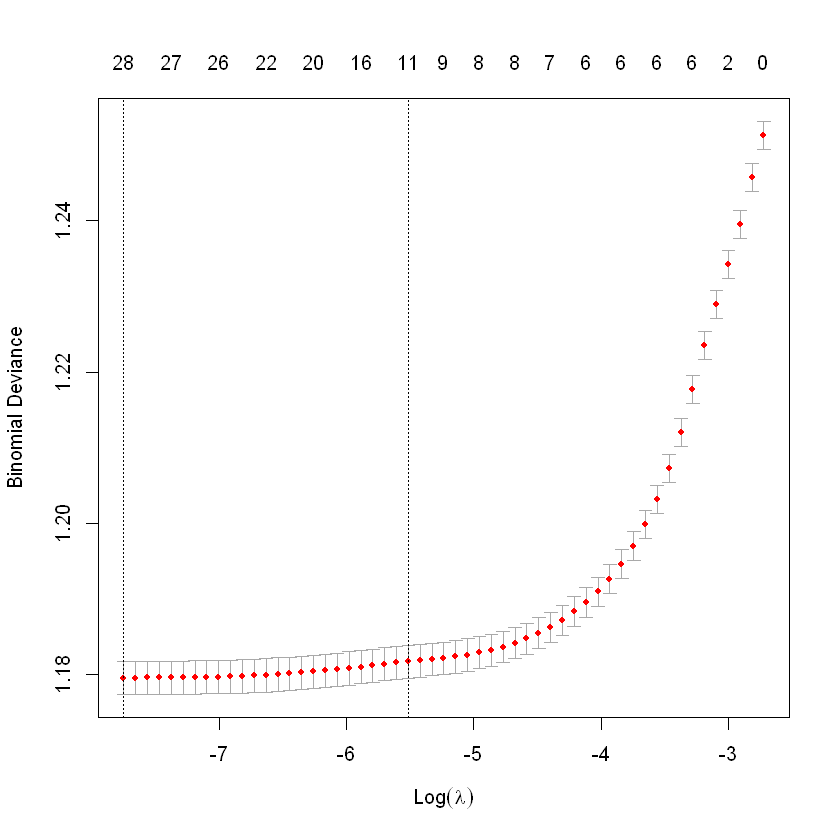

In [54]:
#usamos cross validation
cv.glm.logit <- cv.glmnet(model.matrix(linear,X.train), y.train, alpha = 1, family = 'binomial')
plot(cv.glm.logit)


In [55]:
bestlam <- cv.glm.logit$lambda.1se
coef(cv.glm.logit, s = bestlam)

35 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              -0.815605015
(Intercept)               .          
yob                      -0.122287335
hh_size                   .          
sex                      -0.004410615
city                      0.173216751
g2000                     .          
g2002                     0.149877166
p2000                     0.158145980
p2002                     0.256773517
p2004                     0.338156130
totalpopulation_estimate  .          
percent_male              .          
median_age                0.027876934
percent_62yearsandover    .          
percent_white             .          
percent_black             .          
median_income             .          
employ_20to64            -0.039573571
highschool                0.006640390
bach_orhigher             .          
percent_hispanicorlatino -0.003735525
noise1                    .          
noise2                    .          
noise3  

In [56]:
pre.cv.glm.logit <- as.vector(predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam, type = "response" ))
pre.cv.glm.train <- as.vector(predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam,type = "response"))
pre.lasso.logit <- clasif(pre.cv.glm.logit,0.3)
#predict(cv.glm.logit, newx = model.matrix(linear,X.test), s = bestlam, type = 'class')

lasso_logit_rdos <- c('mse_train' = mse(pre.cv.glm.train,y.train), 'mse_test' = mse(pre.cv.glm.logit, y.test), 'f1' = f1_score(pre.lasso.logit, y.test))
lasso_logit_rdos

Warning message in pred - y_test:
"longitud de objeto mayor no es múltiplo de la longitud de uno menor"


mse_train  mse_test        f1 
0.2298293 0.2016662 0.5046585

In [57]:
rdos <- cbind(rdos, lasso_logit_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso2_rdos,lasso_logit_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324,0.2019577,0.2022936,0.2298293
mse_test,0.2012196,0.2014333,0.2012196,0.2014002,0.2012192,0.2013742,0.2016662
f1,0.5095327,0.5027429,0.5095327,0.5113143,0.5105867,0.5100535,0.5046585


### Elastic net

El método *elastic net* junta las penalizaciones $L1$ y $L2$ en un solo algoritmo. La fórmula del estimador quedaría de la siguiente forma:

\begin{equation}
\hat{\beta}^{en} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2\right)^2 + (1-\alpha) λ\sum_{j=1}^p\beta_j^2+\alpha\lambda\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

Es muy similar a los anteriores solo que ajusta con un parámetro $\alpha$ a cual penalización le da más importancia, LASSO y ridge son casos particulares de elastic net cuando $\alpha = 1$ y cuando $\alpha = 0$ respectivamente.

De esta misma forma se trabaja en R, con la misma función glmnet salvo que ahora el parámetro alpha va estar dentro del intérvalo $(0,1)$. Siendo todo lo demás igual


In [58]:
elastnet.reg <- glmnet( X.train, y.train, alpha = 0.2)

Warning message in plotCoef(x$beta, lambda = x$lambda, df = x$df, dev = x$dev.ratio, :
"1 or less nonzero coefficients; glmnet plot is not meaningful"


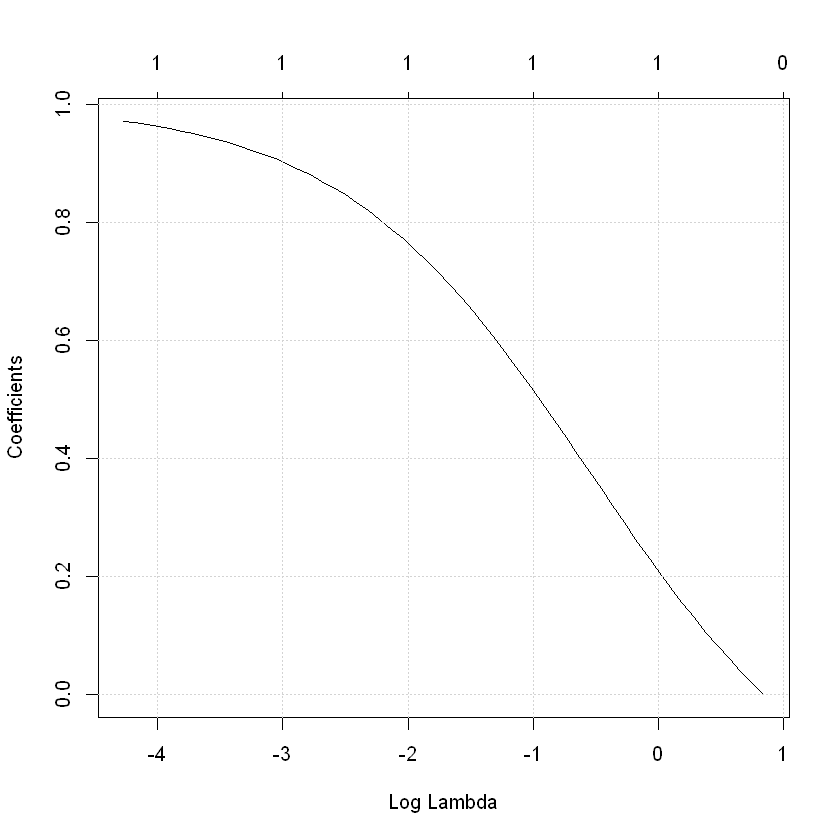

In [59]:
plot(elastnet.reg, xvar = "lambda", label = FALSE)
grid()

La función cv.glmnet no aplica cross-validation sobre el parámetro alpha por lo tanos eso se debe hacer probando varios coeficientes.

In [60]:
elastnet.logit <- cv.glmnet( model.matrix(linear,X.train), y.train, alpha = 0.8, family = 'binomial')
optlambda <- elastnet.logit$lambda.1se

pre.elastnet <- as.vector(predict(elastnet.logit, newx = model.matrix(linear,X.test), s = optlambda, type = "response" ))
pre.elastnet.train <- as.vector(predict(elastnet.logit, newx = model.matrix(linear,X.train), s = optlambda,type = "response"))
pre.elastnet.logit <- clasif(pre.elastnet,0.3)

elastnet_logit_rdos <- c('mse_train' = mse(pre.elastnet.train,y.train), 'mse_test' = mse(pre.elastnet, y.test), 'f1' = f1_score(pre.elastnet.logit, y.test))
elastnet_logit_rdos

mse_train  mse_test        f1 
0.2024417 0.2016733 0.5045114

In [61]:
rdos <- cbind(rdos, elastnet_logit_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso2_rdos,lasso_logit_rdos,elastnet_logit_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324,0.2019577,0.2022936,0.2298293,0.2024417
mse_test,0.2012196,0.2014333,0.2012196,0.2014002,0.2012192,0.2013742,0.2016662,0.2016733
f1,0.5095327,0.5027429,0.5095327,0.5113143,0.5105867,0.5100535,0.5046585,0.5045114


In [62]:
coef(cv.glm.logit, s = optlambda)

35 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)              -0.8131202054
(Intercept)               .           
yob                      -0.1197573140
hh_size                   .           
sex                      -0.0003716016
city                      0.1663460951
g2000                     .           
g2002                     0.1454205845
p2000                     0.1542527256
p2002                     0.2525058987
p2004                     0.3318767969
totalpopulation_estimate  .           
percent_male              .           
median_age                0.0251260777
percent_62yearsandover    .           
percent_white             .           
percent_black             .           
median_income             .           
employ_20to64            -0.0380410025
highschool                0.0016586280
bach_orhigher             .           
percent_hispanicorlatino  .           
noise1                    .           
noise2                

### MCO con variables seleccionadas por LASSO

In [63]:
coef_lasso <- predict(cv_lasso, type = "nonzero") # otra forma de estimar los coeficientes
col <-colnames(model.matrix(linear,X.train))
sel.var <- col[unlist(coef_lasso)]
sel.var

[1] "yob"                      "hh_size"                 
 [3] "sex"                      "city"                    
 [5] "g2000"                    "g2002"                   
 [7] "p2000"                    "p2002"                   
 [9] "p2004"                    "totalpopulation_estimate"
[11] "median_age"               "percent_white"           
[13] "median_income"            "employ_20to64"           
[15] "highschool"               "percent_hispanicorlatino"

In [65]:
# creamos la fórmula con las variables que quedan
linear_lasso <- paste('Y', paste(sel.var, collapse = " + ") , sep = " ~ ")
linear_lasso <- as.formula(linear_lasso)
linear_lasso

Y ~ yob + hh_size + sex + city + g2000 + g2002 + p2000 + p2002 + 
    p2004 + totalpopulation_estimate + median_age + percent_white + 
    median_income + employ_20to64 + highschool + percent_hispanicorlatino

In [66]:
ols_lasso <- lm(linear_lasso, data = X.train)
summary(ols_lasso)


Call:
lm(formula = linear_lasso, data = X.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7699 -0.3381 -0.2185  0.5458  1.0129 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.318390   0.001368 232.746  < 2e-16 ***
yob                      -0.028643   0.001507 -19.011  < 2e-16 ***
hh_size                   0.007688   0.001447   5.313 1.08e-07 ***
sex                      -0.004408   0.001370  -3.218  0.00129 ** 
city                      0.043364   0.001462  29.652  < 2e-16 ***
g2000                    -0.009433   0.001500  -6.287 3.25e-10 ***
g2002                     0.029778   0.001502  19.820  < 2e-16 ***
p2000                     0.037993   0.001406  27.032  < 2e-16 ***
p2002                     0.057121   0.001422  40.163  < 2e-16 ***
p2004                     0.075756   0.001400  54.116  < 2e-16 ***
totalpopulation_estimate  0.012523   0.001755   7.137 9.62e-13 ***
median_age                0.008779   

In [67]:
pred_ols.lasso.train <- predict(ols_lasso, X.train)
pred_ols.lasso <- predict(ols_lasso, X.test)
clas <- clasif(pred_ols.lasso, 0.3) 
ols_lasso_rdos <- c('mse_train' = mse(pred_ols.lasso.train, y.train), 'mse_test' = mse(pred_ols.lasso, y.test), 'f1' = f1_score(clas,y.test))
ols_lasso_rdos

mse_train  mse_test        f1 
0.2020678 0.2012652 0.5089586

In [68]:
rdos <- cbind(rdos, ols_lasso_rdos)
rdos

,ols_rdos,logit_rdos,svm_rdos,ridge_rdos,lasso_rdos,lasso2_rdos,lasso_logit_rdos,elastnet_logit_rdos,ols_lasso_rdos
mse_train,0.2019455,0.2019257,0.2019455,0.2021324,0.2019577,0.2022936,0.2298293,0.2024417,0.2020678
mse_test,0.2012196,0.2014333,0.2012196,0.2014002,0.2012192,0.2013742,0.2016662,0.2016733,0.2012652
f1,0.5095327,0.5027429,0.5095327,0.5113143,0.5105867,0.5100535,0.5046585,0.5045114,0.5089586
